In [1]:
!pip3 install geopandas

In [130]:
# Geo Tools
import geopandas as gpd

# Data Manipulation & Visualisation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
import os

# Own modules
from dataExtraction import extract

# Regression
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [131]:
df = pd.read_csv('data_clean.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,0,0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,...,0,0,0,0,0,1,0,0,0,0
1,1,1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,...,0,0,0,0,0,1,0,0,0,0
2,2,2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,...,0,0,0,0,0,0,0,0,0,0
3,3,3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,...,0,0,0,0,0,0,0,0,0,0
4,4,4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,...,0,0,0,0,0,1,0,0,0,0


In [132]:
df.country.value_counts()

United States     8536
Netherlands        437
Germany            302
Italy              277
France             254
Spain              250
Anywhere           249
United Kingdom     230
Belgium            198
Switzerland        151
Austria            150
Not available      117
Denmark            109
South Africa        19
India               10
Philippines          7
Afghanistan          5
Suriname             3
Argentina            3
Serbia               2
Mali                 1
Portugal             1
Name: country, dtype: int64

## Exploratory Data Analysis (EDA)

### 1. Geographic Distribution of Jobs

Reading in the geolocation cache in order to access stored coordinates. 

In [133]:
locations_df = pd.read_csv('locations_cache.csv')
locations_df.set_index('location', inplace=True) 

Retrieve latitude and longitude from the geo-cache in order to aid in geographic distribution visualization.

In [134]:
location_count = df['location'].value_counts().reset_index()  # Determine the no. jobs in each location
location_count.rename(columns={'index': 'location', 'location': 'location_count'},
                                      inplace=True)

def retrieve_coordinates(x):  # Retrieve the lat and long from a listing location
    location = x['location']
    x['latitude'] = locations_df.loc[location, 'latitude']
    x['longitude'] = locations_df.loc[location, 'longitude']
    return x

location_count = location_count.apply(retrieve_coordinates, axis=1)
location_count = location_count[location_count.latitude != 'Not available']  # Remove Not availabel coordinates

print(location_count.head())
print(location_count.shape)

                 location  location_count    latitude    longitude
0           United States             622  39.7837304  -100.445882
1       New York, NY, USA             561  40.7127281  -74.0060152
2  San Francisco, CA, USA             317  37.7790262  -122.419906
4        Chicago, IL, USA             224  41.8755616  -87.6244212
5         Boston, MA, USA             202  42.3554334   -71.060511
(891, 4)


#### 1.1 World Map

Visualize the job listing locations, as a heatmap overlayed onto a world-map. This visualization displays locations of high listing quantities versus, comparatively low quantities. 

Inspiration for the visualization from: https://towardsdatascience.com/easiest-way-to-plot-on-a-world-map-with-pandas-and-geopandas-325f6024949f

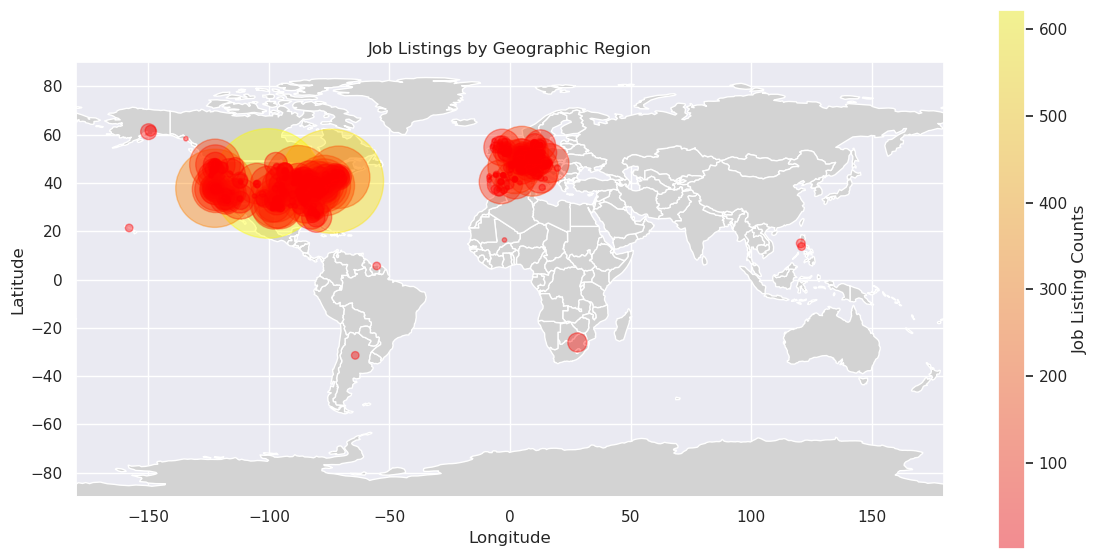

In [135]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))  # Generate world map


fix, ax = plt.subplots(figsize=(14, 7))  # Specify plot size
worldmap.plot(color="lightgrey", ax=ax)  # Specify map colour

lat = location_count['latitude'].astype(float)  # Convert coords and counts to floats
long = location_count['longitude'].astype(float)
listing_count = location_count['location_count'].astype(float)


plt.scatter(x=long, y=lat, s=listing_count * 10, c=listing_count, alpha=0.4, cmap='autumn')
plt.colorbar(label='Job Listing Counts')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Job Listings by Geographic Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### 1.2 Country Distribution

Visualize the quantity of job listing per country. 
Seperate the listings that provide salary information from those not providing salary information.

In [137]:
df_geo = df[df.country != 'Not available'].copy()
df_geo['salary_extracted'] = df_geo.euro_value != 'Not available'  # Boolean column indicating a salary was extracted from the listing

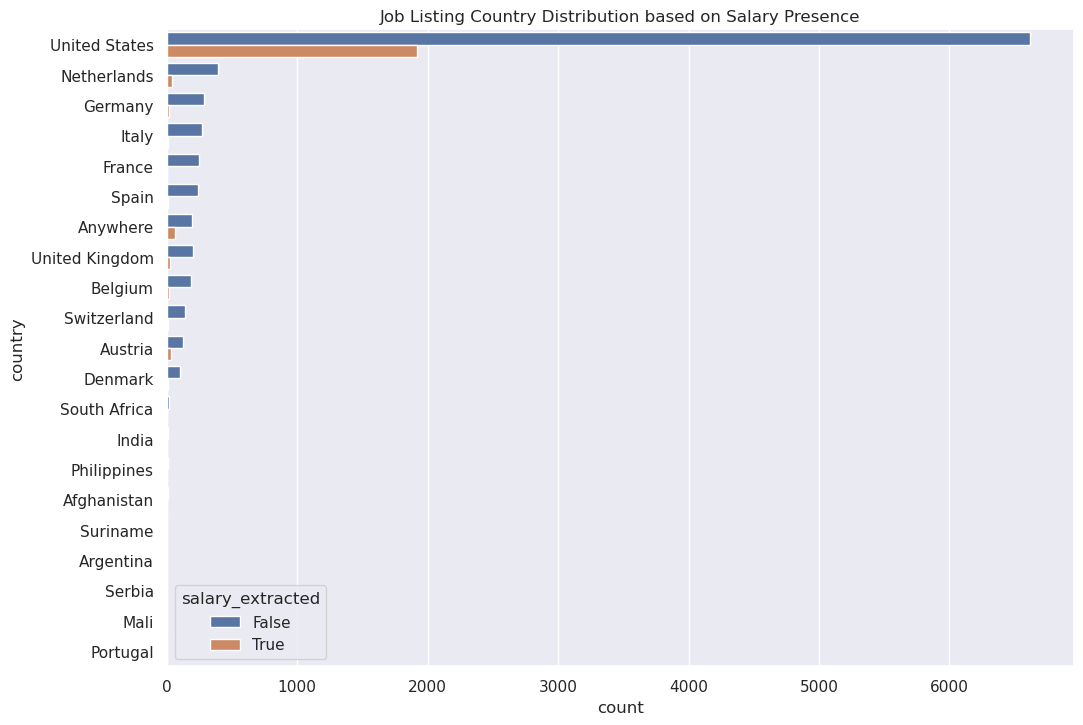

In [138]:
sns.countplot(data=df_geo, y='country', hue='salary_extracted', order=df_geo.country.value_counts().index)
plt.title('Job Listing Country Distribution based on Salary Presence')
plt.show()

##### 1.2.1 Country Distribution (USA excluded)

The vast difference in data between the United States of America and the other countries scraped, makes it difficult to see their contribution. The below visualization excludes the United States, making other countries contributions easier to view. 

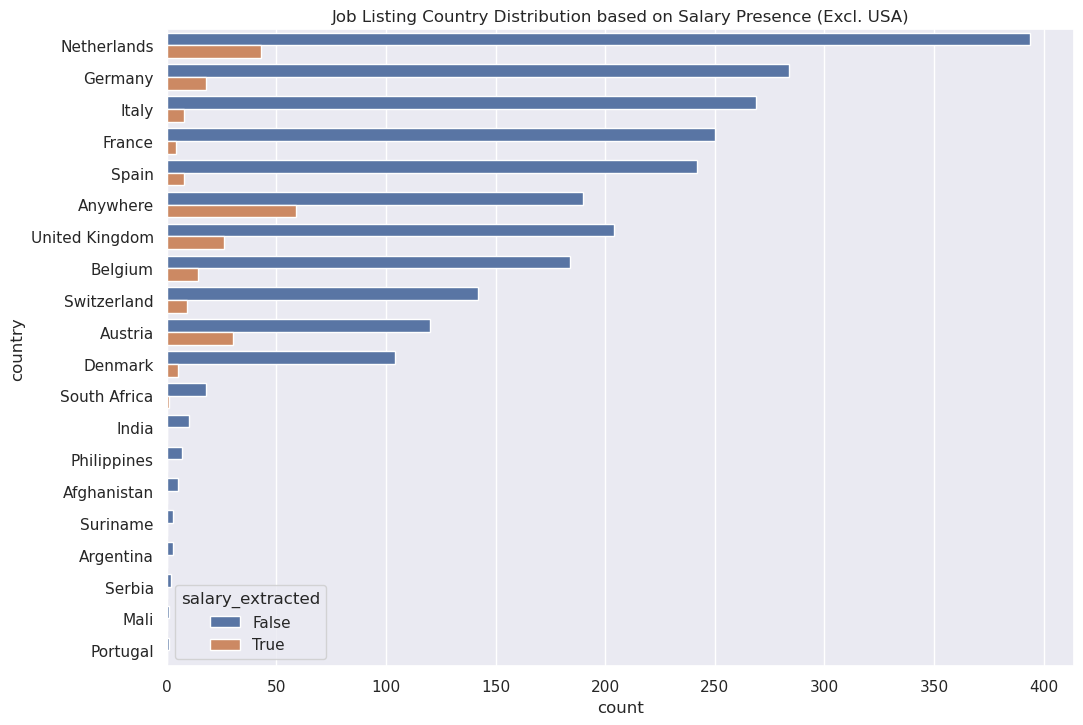

In [141]:
df_ex_usa = df_geo[df_geo.country != 'United States']
sns.countplot(data=df_ex_usa, y='country', hue='salary_extracted', order=df_ex_usa.country.value_counts().index)
plt.title('Job Listing Country Distribution based on Salary Presence (Excl. USA)')
plt.show()

### 2. Data Science Skills

Visualize the in-demand skills of Data Scientists as determined by job listing analysis.

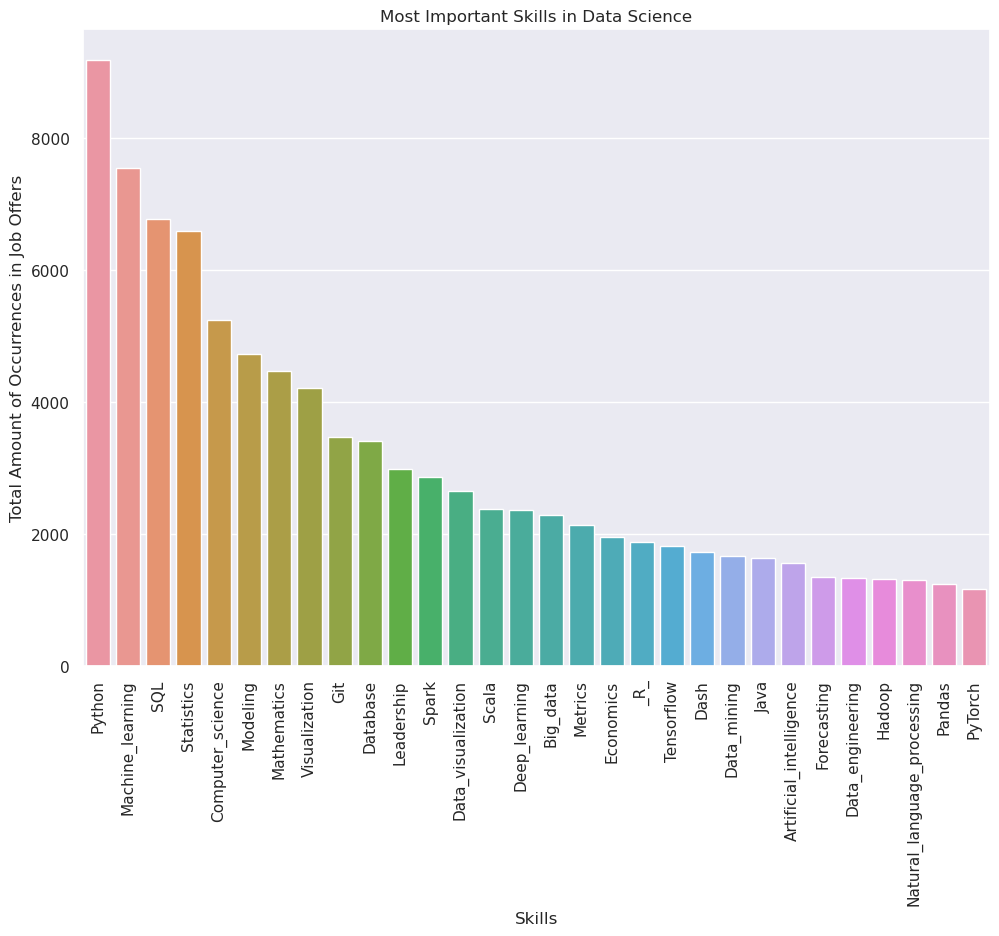

In [143]:
# Create bar-chart for top n skills

starting_index = df.columns.get_loc("Apache_Spark")  # This is the first df column where the skills are starting

skills_df = df.iloc[:, starting_index:]
skills_df_sum = pd.DataFrame(skills_df.sum())
skills_df_sum.rename(columns={ skills_df_sum.columns[0]: "amount" }, inplace = True)
skills_df_sum = skills_df_sum.sort_values(by=["amount"], ascending=False)


# Set n
n = 30
skills_df_sum_top = skills_df_sum.head(n)
skills_df_sum_top

# Create chart'>' not supported between instances of 'numpy.ndarray' and 'str'
sns.barplot(data=skills_df_sum_top, x=skills_df_sum_top.index, y="amount")
plt.xticks(rotation=90)
plt.xlabel("Skills")
plt.ylabel("Total Amount of Occurrences in Job Offers")
plt.title("Most Important Skills in Data Science")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

### 3. Salary

#### 3.1 Initial Salary Exploration
The salary information was collected through NLP, so all of the salary data must be converted to floating point values, with any of the 'Not available' salaries removed.  We can do this and check how many salaries are left within the dataset

In [144]:
print(f"{df.euro_value.count()} records available prior to removing NA")
df = df[df.euro_value != 'Not available']
df.euro_value = df.euro_value.astype(float)
print(f"No. of salaries: {df.euro_value.count()}")
print(f"max salary: {df.euro_value.max()}")
print(f"min salary: {df.euro_value.min()}")
print(f"mean salary: {df.euro_value.mean()}")

11311 records available prior to removing NA
No. of salaries: 2140
max salary: 187999283.33641577
min salary: 1.8494544109487703
mean salary: 3003397.835104409


When we inspect the salaries, we can see that there are outliers within the data, the minimum salary is just 2!  This is likely due to the fact that the salaries are not listed and the NLP is picking up the most likely number that represents a salary.

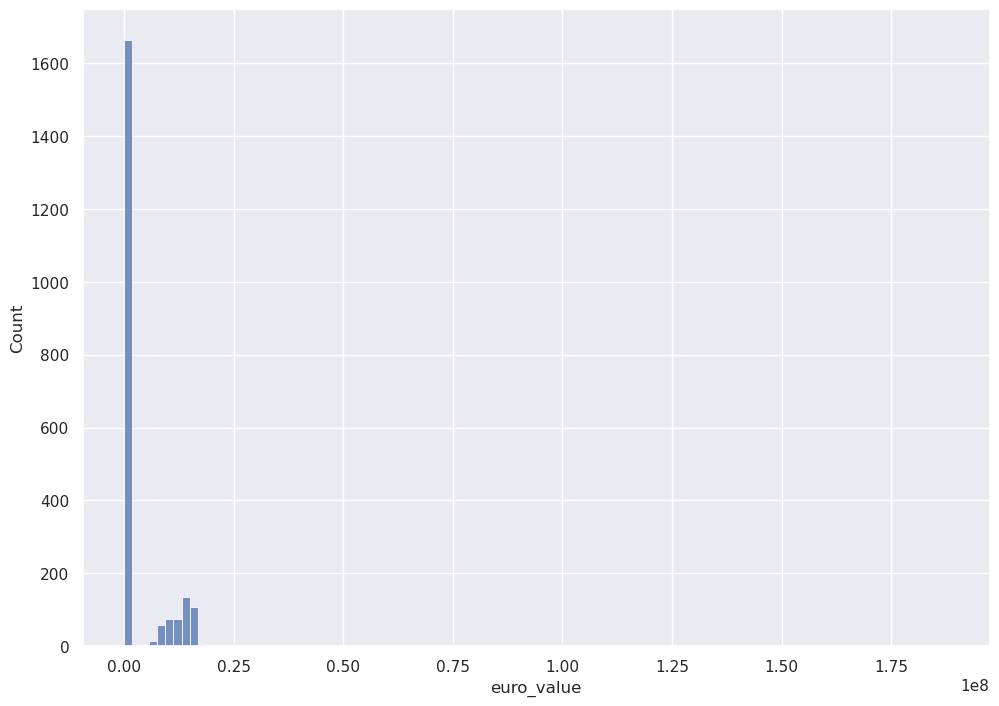

In [145]:
ax = sns.histplot(df.euro_value, bins=100)

We also seem to have some incredibly high salaries that are well outside the values we would expect of the data.  We can use the code below to inspect the detail of the high and low salaries to try and make sense of what is occuring to provide these results.

### 3.2 Salary Cleaning

In [146]:
print(f"Salaries above 100,000: {df.euro_value[df.euro_value>100000].count()}")
print(f"Salaries below 15,000: {df.euro_value[df.euro_value<=15000].count()}")

Salaries above 100,000: 1569
Salaries below 15,000: 495


In [147]:
index = 0
value = 10
df_temp = df[df.euro_value < value]

print(f"{df_temp.euro_value.count()} salaries below {value}\n ---------- ")
print(f"Salary: {df_temp.euro_value.iloc[index]} \n ---------- ")
print(df_temp.description.iloc[index])

98 salaries below 10
 ---------- 
Salary: 3.5 
 ---------- 
Ervaring: Medior (2-5 jr) Expertise: Data Location: Vianen Sogeti is een organisatie met een goede werksfeer en zo min mogelijk hiërarchische verhoudingen. Ga je bij ons als AI Data Scientist aan de slag? Dan kun je rekenen op honderden collega’s die klaarstaan om klanten te helpen, en ook elkaar graag een helpende hand bieden. Sogetisten gaan niet alleen voor goede resultaten, maar ook voor lol tijdens het werk. Deze snelgroeiende groep collega’s krijgt energie van hun vak en dat merk je op de werkvloer. Sogeti is een fijne werkgever en geeft jou de ruimte om de inhoud in te duiken! Werken bij Sogeti Als Data Scientist help je onze klanten vertrouwd te maken met verwerken van complexe data door middel van machine learning, data mining en deep learning technologieën. Je zet statistische modellen en voorspellende algoritmes in om verborgen patronen te onthullen. Daarbij ontwikkel je end-tot-end oplossingen om je werk te operati

Looking into the detail of the job description, most salaries at the extreme low end don't make any mention of the actual renumneration.  The NLP classifier picked up other parts of the job description instead.  Things like "8% Holiday Payment" and "2 - 5 years experience" were red herrings.

In [148]:
index = 4
value = 160000
df_temp = df[df.euro_value > value]

print(f"{df_temp.euro_value.count()} salaries above {value}\n ---------- ")
print(f"Salary: {df_temp.euro_value.iloc[index]} \n ---------- ")
print(df_temp.description.iloc[index])

768 salaries above 160000
 ---------- 
Salary: 165000.0 
 ---------- 
At Coalition Inc. (Permanent), in Multiple LocationsSalary: $125.000 - $205.000Expires at: 2023-05-11Remote policy: Full remoteTo apply for this role, the candidates must be located in USA or Canada. About the RoleAs Senior Data Scientist, Product Analytics at Coalition you will be responsible for measuring, understanding, and helping optimize Coalition’s largest revenue channel. You will use analytics, experimentation, and modern statistical techniques to help us understand and improve our cyber insurance customer experience to grow our revenue safely and efficiently. This role requires partnering with our head of revenue and other key stakeholders to quickly identify emerging trends in our customer data and effectively communicate clear, actionable strategies across the company. ResponsibilitiesLead cross-functional projects using quantitative analysis and advanced data modeling to discover insights that will guide

At the higher end of the spectrum, the extremely high salaries often occured due to the difference in numbering styles between countries.  German and Dutch numbering systems use a comma ',' to denote the euro/cents seperator and the full stop '.' to denote the thousands seperator.  Additionally some of the US/UK formatted data included the pennies/cents seperator which also seems to have thrown off the classifer (i.e. "The range for this position is: 128,000.00 - 214,000.00 USD annually").  To address this, we can quite confidently remove any salary above 160,000, or scale them by dividing by 100.

,Unnamed: 0.1,Unnamed: 0,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
1,1,1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,...,0,0,0,0,0,1,0,0,0,0
4,4,4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,...,0,0,0,0,0,1,0,0,0,0
8,8,8,"LEAD DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Rotterdam,LinkedIn,Employment type: Full-time & Permanent Reports...,Employment type: Full-time & PermanentReports ...,"{'posted_at': '1 day ago', 'schedule_type': 'F...",eyJqb2JfdGl0bGUiOiJMRUFEIERBVEEgU0NJRU5USVNUIC...,...,0,0,0,0,0,1,0,0,0,0
11,11,11,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,...,0,0,0,0,0,1,0,0,0,0
14,14,14,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,...,0,0,0,0,0,1,0,0,0,0


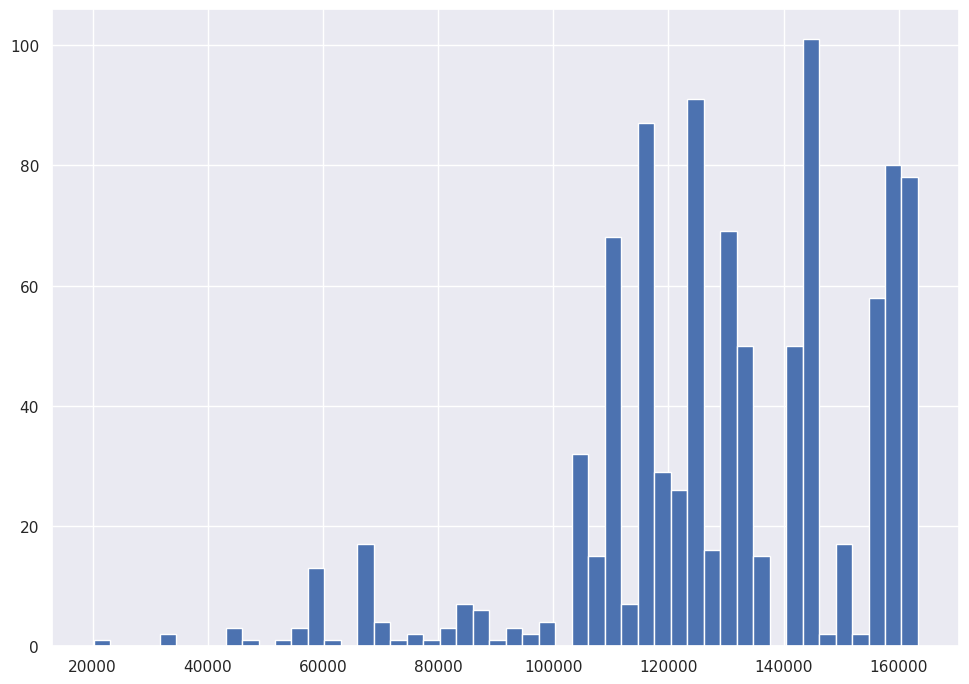

In [149]:
df_clean = df[df.euro_value > 15000]
df_clean = df_clean[df_clean.euro_value < 165000]
df_clean.euro_value.hist(bins=50)
df_clean.head()

### 3.3 Salary per Country


In [150]:
df_temp = df_clean[df_clean.country != 'Not available']  # Remove Not available countries

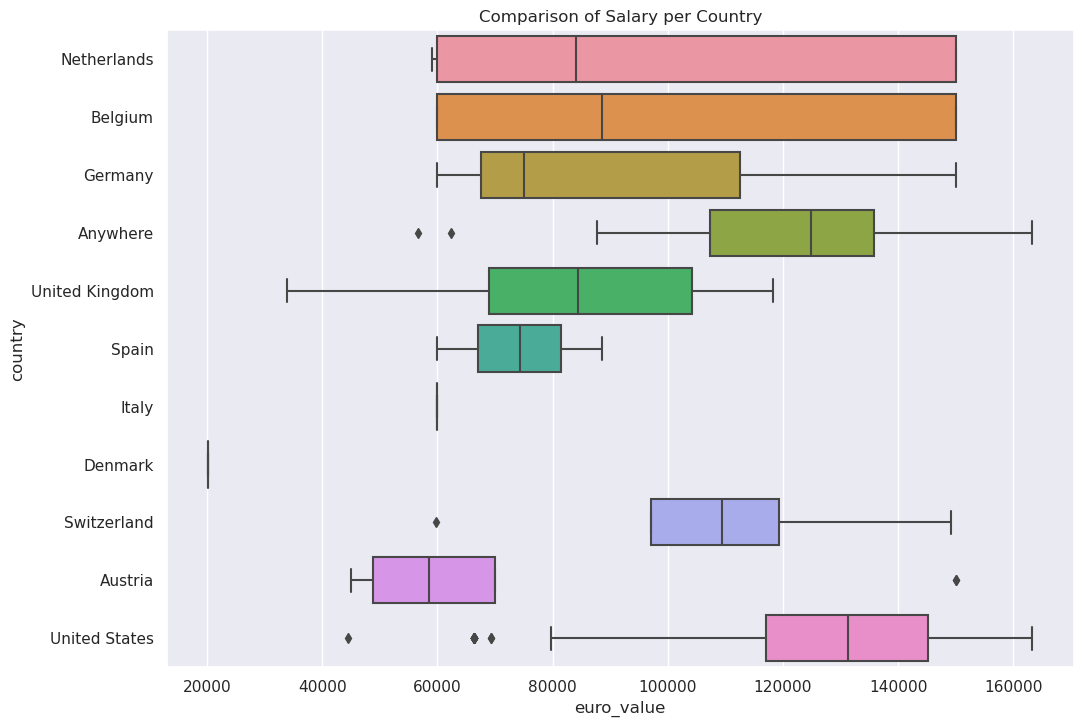

In [151]:
sns.boxplot(data=df_temp, x='euro_value', y='country')
plt.title("Comparison of Salary per Country")
plt.show()

## Modelling 
#### Disclaimer:
This notebook uses the code given in clinic 2 as reference to build and train the regression model.

In [152]:
def get_rmse(actual, predicted):
    error = np.sqrt(np.sum((actual - predicted)**2) / len(actual))
    return error

In [153]:
# Build regression model
starting_index = df_clean.columns.get_loc('Apache_Spark')  # This is the first df column where the skills are starting

reg_columns = ['euro_value']
reg_columns += df_clean.iloc[:, starting_index:].columns.tolist()

# Select relevant columns
reg_df = df_clean.reindex(columns=reg_columns)

# Split data into x and y for the regression model
X = reg_df.drop(['euro_value'], axis = 1)
y = reg_df['euro_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_test = y_test.astype(float)

In [155]:
alphas = np.arange(0.1, 200.1, .1)
model = lm.LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=200, tol=1e-2)
model.fit(X_train, y_train)

LassoCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 1.998e+02, 1.999e+02,
       2.000e+02]),
        cv=5, fit_intercept=False, max_iter=200, tol=0.01)

In [156]:
y_fitted = model.predict(X_train).astype(float)
y_predicted = model.predict(X_test).astype(float)

[]

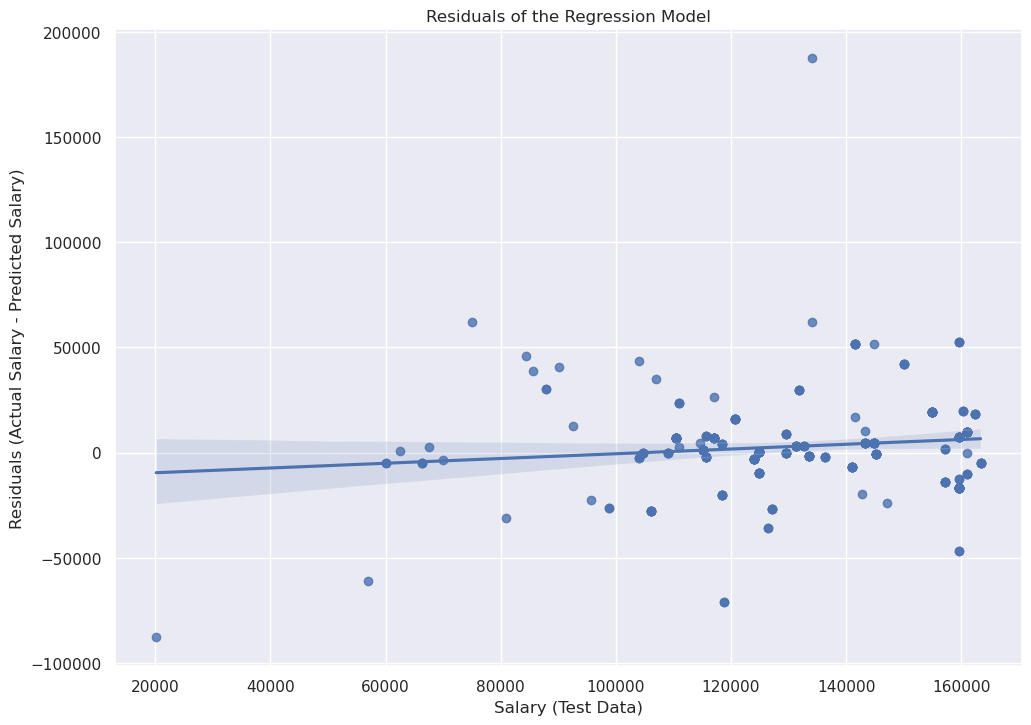

In [157]:
# Plot residuals
fm_residuals = y_test - y_predicted
sns.regplot(x=y_test, y=fm_residuals)
plt.xlabel('Salary (Test Data)')
plt.ylabel('Residuals (Actual Salary - Predicted Salary)')
plt.title('Residuals of the Regression Model')
plt.plot()